## **EDA**

In [5]:
%load_ext autoreload
%load_ext sql
%autoreload 2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys 
import os
import sqlite3
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
project_root = os.path.abspath(os.path.join(".."))  
if project_root not in sys.path:
    sys.path.append(project_root)
from data import AlphaVantageAPI , SQLRepository
from utils.config import settings   


ETL data 

In [8]:
#instantiate the api 
api= AlphaVantageAPI()

#extracting and transform data from api 
ambuja_company =api.get_daily(ticker="AMBUJACEM.BSE")
suzlon_company = api.get_daily(ticker="SUZLON.BSE")

#connecting to the database  
connection =sqlite3.connect(settings.db_name ,check_same_thread=False)
repo=SQLRepository(connection=connection)

#loading data into the database 
repo.insert_table(table_name="AMBUJACEM.BSE" , records=ambuja_company ,if_exists="replace")
repo.insert_table(table_name="SUZLON.BSE" , records=suzlon_company ,if_exists="replace")


https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?function=TIME_SERIES_DAILY&symbol=AMBUJACEM.BSE&outputsize=full&datatype=json&apikey=6d732957a3ace12cd2eba6d33e8d31170cb7e5a648b357a3c9b0fc09c8c2676c51a00c781067c24210f835f5a4cd1ac2454aa227e7a3b6dc023454126a7f86ed2933a9a9a82316fb17b133595c7fde5a6567584cfb0c48e219378a464455ec64a07323da152964acf898af7ea876c03f66ad914b67dd995a74a9346207574cb6
https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?function=TIME_SERIES_DAILY&symbol=SUZLON.BSE&outputsize=full&datatype=json&apikey=6d732957a3ace12cd2eba6d33e8d31170cb7e5a648b357a3c9b0fc09c8c2676c51a00c781067c24210f835f5a4cd1ac2454aa227e7a3b6dc023454126a7f86ed2933a9a9a82316fb17b133595c7fde5a6567584cfb0c48e219378a464455ec64a07323da152964acf898af7ea876c03f66ad914b67dd995a74a9346207574cb6


{'transaction_successful': True, 'records_inserted': 4958}

reading data from database 

In [9]:
#reading companies data from the data =base 
df_ambuja=repo.read_table(table_name="AMBUJACEM.BSE", limit=2000)
df_suzlon =repo.read_table(table_name="SUZLON.BSE", limit=2000)

In [12]:
print (f"df_ambuja shape : {df_ambuja.shape}")

df_ambuja.head()

df_ambuja shape : (2000, 5)


,open,high,low,close,volume
date,,,,,
2025-12-05,536.45,537.35,532.00,533.85,21462.0
2025-12-04,537.00,543.50,527.35,536.75,180392.0
2025-12-03,545.50,545.70,534.05,535.65,22005.0
2025-12-02,546.15,546.90,541.10,542.95,25491.0
2025-12-01,550.35,551.90,542.85,543.30,19808.0


In [13]:
print (f"df_suzlon shape : {df_suzlon.shape}")

df_suzlon.head()

df_suzlon shape : (2000, 5)


,open,high,low,close,volume
date,,,,,
2025-12-05,51.01,52.15,50.77,51.75,8201537.0
2025-12-04,52.51,52.83,50.60,50.85,10605850.0
2025-12-03,53.59,53.62,52.15,52.59,9647592.0
2025-12-02,53.95,54.09,53.23,53.43,4357776.0
2025-12-01,54.18,54.75,53.54,53.75,2705284.0


discovring the close columns for both companies

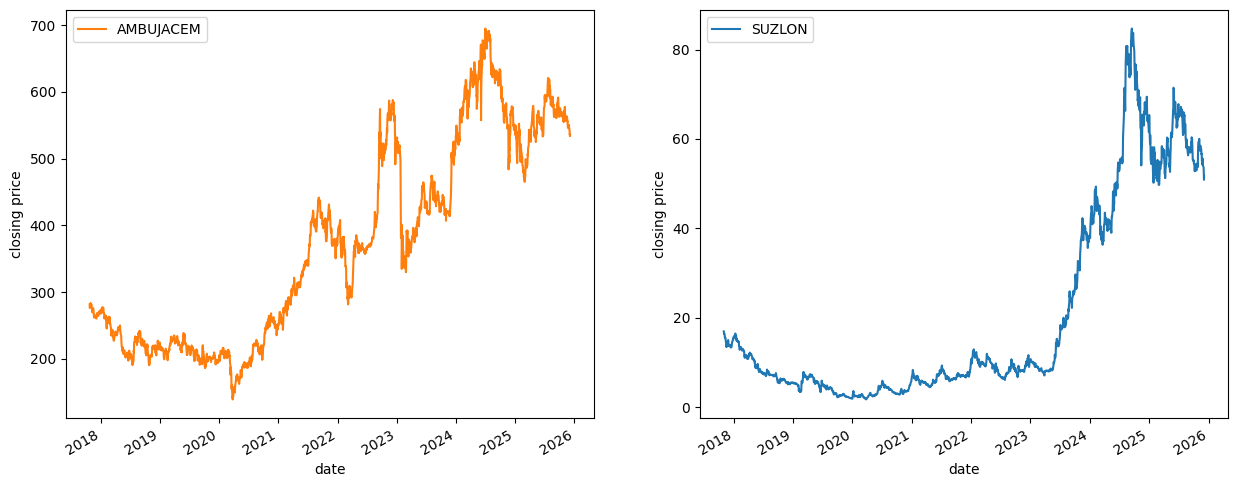

In [25]:
fig,ax =plt.subplots(1,2 ,figsize=(15,6))

df_ambuja["close"].plot(ax=ax[0], label="AMBUJACEM" ,color="C1")
df_suzlon["close"].plot(ax=ax[1],label="SUZLON")

ax[0].set_ylabel("closing price")
ax[1].set_ylabel("closing price")

ax[0].legend()
ax[1].legend()

plt.show()


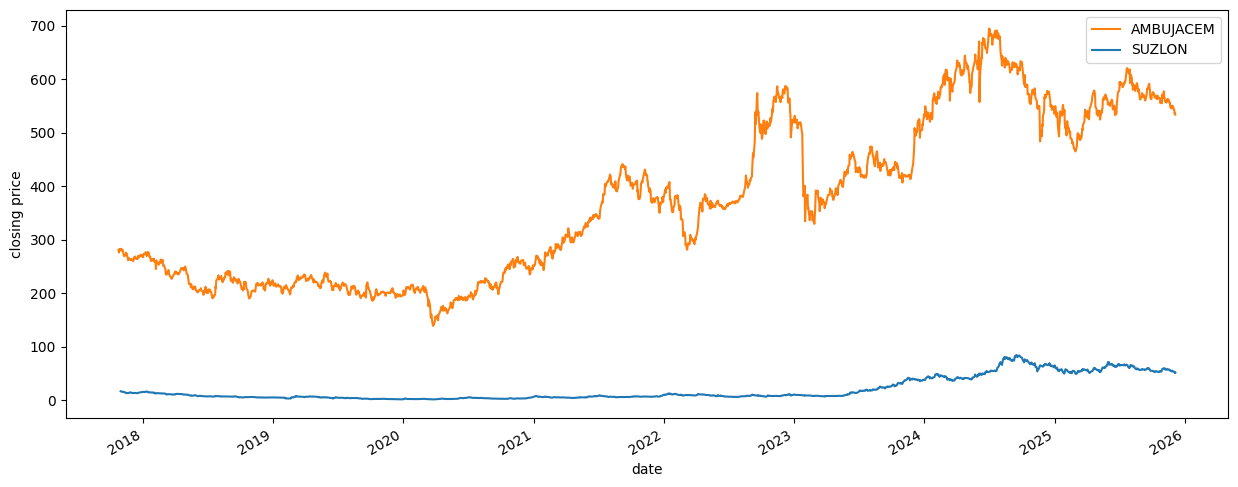

In [26]:
fig ,ax = plt.subplots(figsize=(15,6))

df_ambuja["close"].plot(ax=ax, label="AMBUJACEM" ,color="C1")
df_suzlon["close"].plot(ax=ax,label="SUZLON")

plt.xlabel("date")
plt.ylabel("closing price")

plt.legend();

Looking at this plot, we might conclude that Ambuja Cement is a "better" stock than Suzlon energy because its price is higher. But price is just one factor that an investor must consider when creating an investment strategy. What is definitely true is that it's hard to do a head-to-head comparison of these two stocks because there's such a large price difference.

One way in which investors compare stocks is by looking at their returns instead. A return is the change in value in an investment, represented as a percentage. So let's look at the daily returns for our two stocks.

Adding return feature for both companies 

In [38]:
#sort dataframes by index ascending 
df_ambuja.sort_index(ascending=True, inplace= True )
df_suzlon.sort_index(ascending=True , inplace = True )
#adding retrun feat
df_ambuja["return"]=df_ambuja["close"].pct_change()*100
df_suzlon["return"]=df_suzlon["close"].pct_change()*100

#droping null values
df_suzlon.dropna(inplace=True)
df_ambuja.dropna(inplace=True)

print ("AMBUJA DATFRAME :",end="\n \n")
print(f"shape of df_ambuja : {df_ambuja.shape}")
print ("summary of df_ambuja columns : " ,end="\n \n")
print (df_ambuja.info())
print()
print (df_ambuja.head())

print("*"*100)
print ("SUZLON  DATFRAME :",end="\n \n \n ")
print(f"shape of df_suzlon : {df_suzlon.shape}")
print ("summary of df_suzlon columns : " ,end="\n \n")
print (df_suzlon.info())
print()
print (df_suzlon.head())



AMBUJA DATFRAME :
 
shape of df_ambuja : (1999, 6)
summary of df_ambuja columns : 
 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1999 entries, 2017-10-26 to 2025-12-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1999 non-null   float64
 1   high    1999 non-null   float64
 2   low     1999 non-null   float64
 3   close   1999 non-null   float64
 4   volume  1999 non-null   float64
 5   return  1999 non-null   float64
dtypes: float64(6)
memory usage: 109.3 KB
None

              open    high     low   close    volume    return
date                                                          
2017-10-26  283.30  283.30  274.05  276.15  707958.0 -1.935369
2017-10-27  279.00  280.00  276.70  279.20  551404.0  1.104472
2017-10-30  276.00  286.25  276.00  283.15  175886.0  1.414756
2017-10-31  283.70  288.65  281.10  281.75  142149.0 -0.494438
2017-11-01  282.55  287.00  282.20  282.75   72269.0  0.354925
******

plotting the daily return for both companies

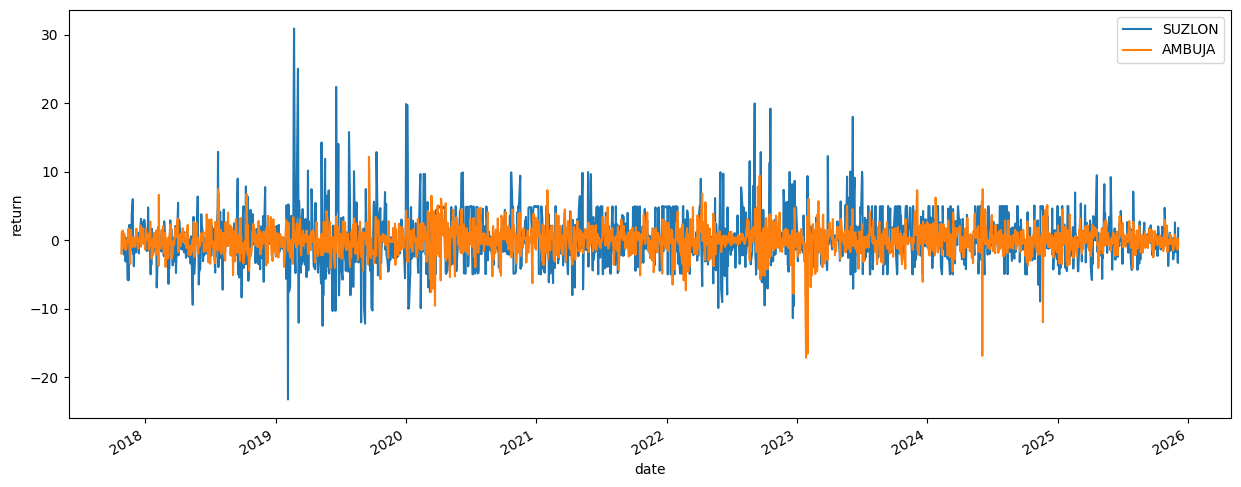

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot returns for `df_suzlon` and `df_ambuja`
df_suzlon["return"].plot(ax=ax ,label="SUZLON")
df_ambuja["return"].plot(ax=ax ,label="AMBUJA" ,color="C1")


# Label axes
plt.xlabel("date")
plt.ylabel("return")


# Add legend
plt.legend();

ok now it seems like suzlon company have more volatility than ambujacem 

lets explor volatility more 

unconditional volatility 

In [39]:
y_ambuja=df_ambuja["return"]
y_suzlon=df_suzlon["return"]

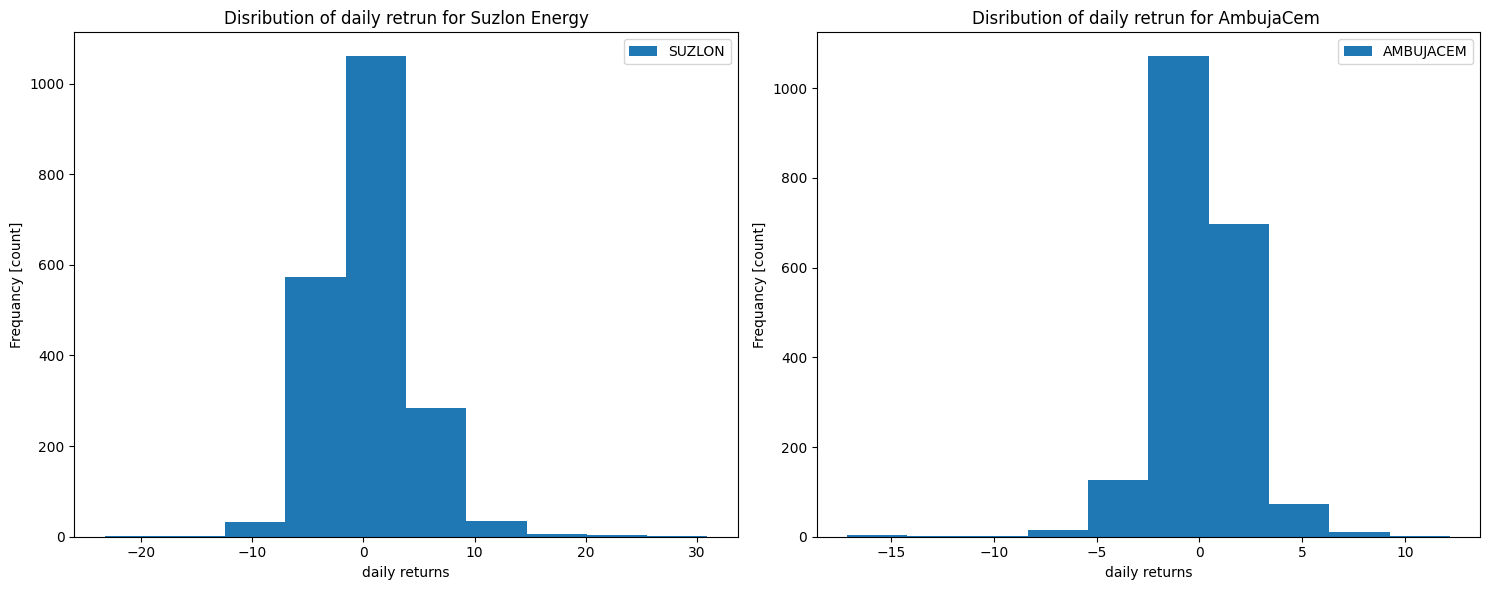

In [48]:
fig,ax=plt.subplots(1,2 , figsize=(15,6))
ax[0].hist(y_suzlon ,label="SUZLON")
ax[1].hist(y_ambuja, label="AMBUJACEM" )

ax[0].set_xlabel("daily returns")
ax[0].set_ylabel("Frequancy [count]")
ax[1].set_xlabel("daily returns")
ax[1].set_ylabel("Frequancy [count]")

ax[0].legend()
ax[1].legend()

ax[0].set_title("Disribution of daily retrun for Suzlon Energy")
ax[1].set_title("Disribution of daily retrun for AmbujaCem ")
fig.tight_layout()



In [49]:
suzlon_daily_volatility =y_suzlon.std()
ambuja_daily_volatility = y_ambuja.std()

print("Suzlon Daily Volatility:", suzlon_daily_volatility)
print("Ambuja Daily Volatility:", ambuja_daily_volatility)

Suzlon Daily Volatility: 3.85609189635783
Ambuja Daily Volatility: 2.0675420048286224


In [50]:
suzlon_annual_volatility = suzlon_daily_volatility*np.sqrt(252)
ambuja_annual_volatility =  ambuja_daily_volatility*np.sqrt(252)

print("Suzlon Annual Volatility:", suzlon_annual_volatility)
print("Ambuja Annual Volatility:", ambuja_annual_volatility)

Suzlon Annual Volatility: 61.21356114224563
Ambuja Annual Volatility: 32.82121181973864


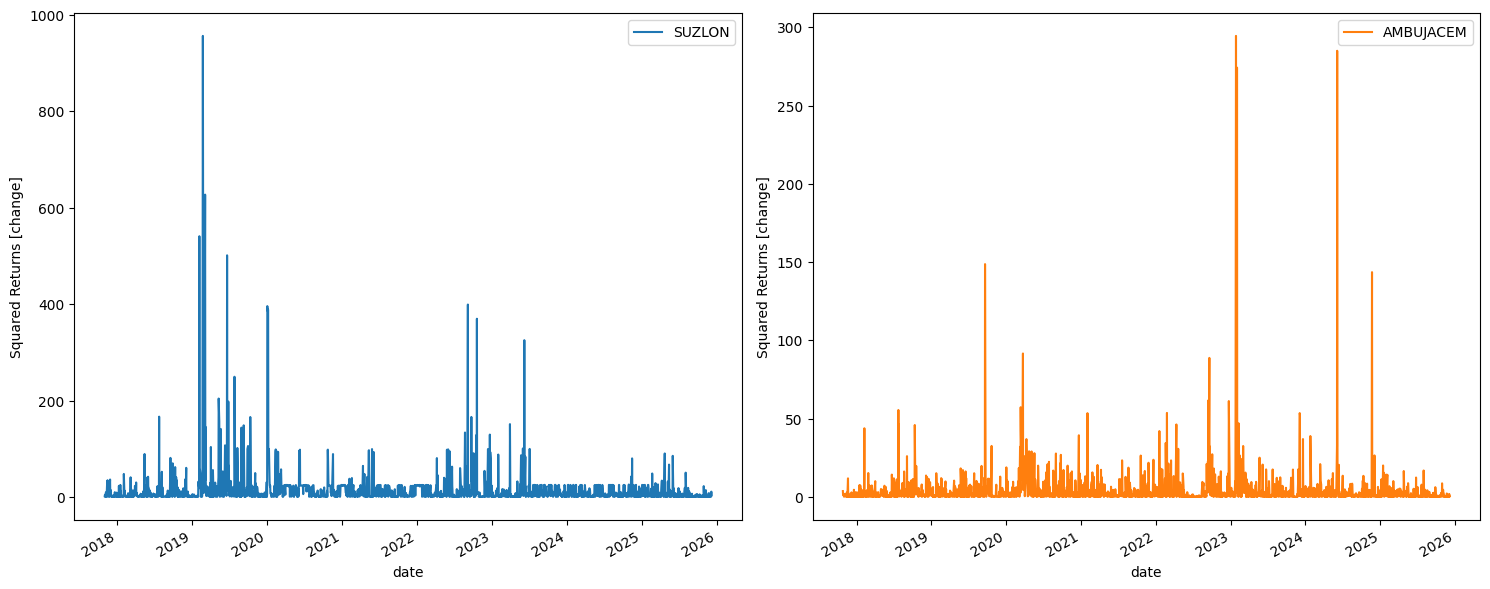

In [52]:
fig,ax=plt.subplots(1,2 , figsize=(15,6))
(y_ambuja**2).plot(ax=ax[1] ,color="C1" , label="AMBUJACEM")
(y_suzlon**2).plot(ax=ax[0],label= "SUZLON")


ax[0].set_xlabel("date")
ax[0].set_ylabel("Squared Returns [change]")
ax[1].set_xlabel("date")
ax[1].set_ylabel("Squared Returns [change]")

ax[0].legend()
ax[1].legend()

fig.tight_layout()


so from the previous exploration we fin out that suzlon has more volatility than ambujacem and at the last fig we saw that suzlon company has bigger return changes over time and thats explane why it has more volatility than ambujacem 